# Workflow

## Imports

In [1]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, transform
from skimage.transform import radon, iradon

## Pipeline

In [2]:
# Specify path to imgs
path_mandarine = "C:/Users/caram/Documents/2024-08-21-Messungen/2024-08-21-Mandarine-100kV-1200muA/000.TIFF"
path_empty = "C:/Users/caram/Documents/2024-08-21-Messungen/2024-08-21-Empty/01_100KV_1200MUA.TIFF"

### Ignore: Img Analysis

In [3]:
_img_mandarine = cv2.imread(path_mandarine,cv2.IMREAD_UNCHANGED)
img_empty = cv2.imread(path_empty,cv2.IMREAD_UNCHANGED)

In [4]:
minmand = np.min(_img_mandarine)
maxmand = np.max(_img_mandarine)

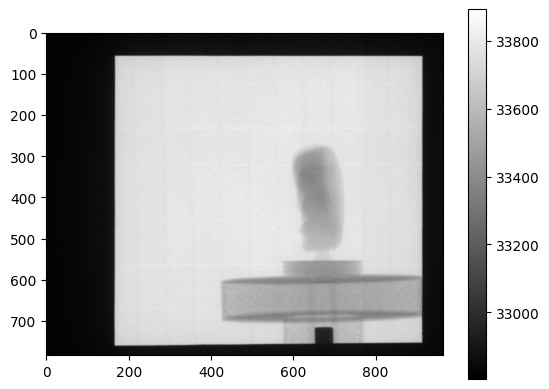

In [5]:
plt.imshow(_img_mandarine, cmap="grey", vmin=minmand, vmax=maxmand)
plt.colorbar()

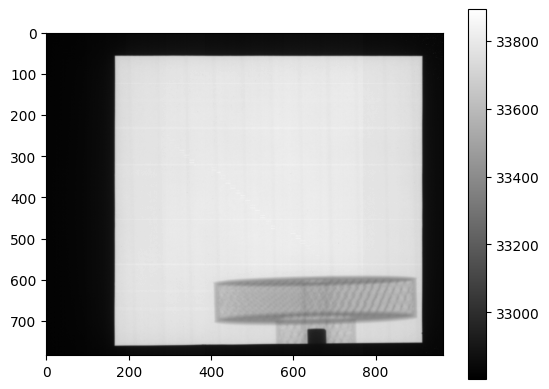

In [6]:
plt.imshow(img_empty, cmap="grey", vmin=minmand, vmax=maxmand)
plt.colorbar()

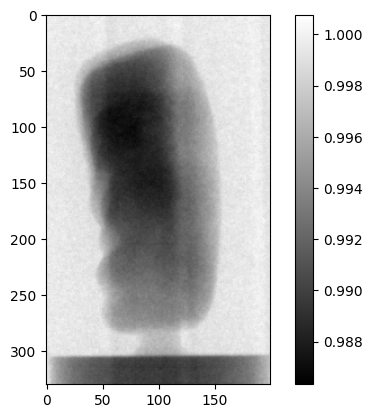

In [7]:
plt.imshow((_img_mandarine/img_empty)[250:580,570:770], cmap="grey")
plt.colorbar()

### Corrections (FF)

In [8]:
# Apply flatfield to all imgs & Save into an array

img_empty = img_empty = cv2.imread(path_empty,cv2.IMREAD_UNCHANGED)
folder_path = "C:/Users/caram/Documents/2024-08-21-Messungen/2024-08-21-Mandarine-100kV-1200muA/"

tiff_files = sorted(glob.glob(os.path.join(folder_path, '*.TIFF')))
if not tiff_files:
    print("Empty or no TIFF")
else:
    first_image = cv2.imread(tiff_files[0],cv2.IMREAD_UNCHANGED)
    
    if first_image is None:
        print(f"Failed to read first file: {tiff_files[0]}")
    else:
        height,width = first_image.shape[:2]
        num_images = len(tiff_files)
        
        Z = np.zeros((height,width,num_images))         # For uncorrected imgs
        Z_corr = np.zeros((height,width,num_images))    # For flatfield corrected imgs
    
        for i, file_path in enumerate(tiff_files):
            image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
            
            if image is None:
                print(f"Failed to read {file_path}")
            else:
                Z[:, :, i] = image
                Z_corr[:, :, i] = np.abs(1-image/img_empty)  # Store flatfield corrected image in the 3D array at index i
        
        # Display final information
        print(f"Stored {num_images} images in the 3D array Z & Z_corr with shape: {Z.shape}")

Stored 100 images in the 3D array Z & Z_corr with shape: (784, 964, 100)


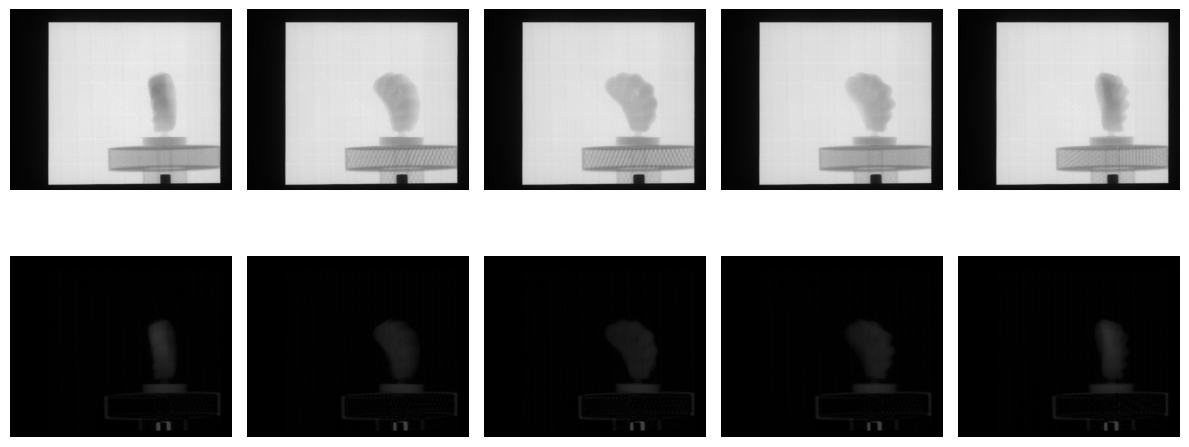

In [9]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs[0,0].imshow(Z[:,:,0], cmap="grey")
axs[0,1].imshow(Z[:,:,20], cmap="grey")
axs[0,2].imshow(Z[:,:,40], cmap="grey")
axs[0,3].imshow(Z[:,:,60], cmap="grey")
axs[0,4].imshow(Z[:,:,80], cmap="grey")

axs[1,0].imshow(Z_corr[:,:,0], cmap="grey")
axs[1,1].imshow(Z_corr[:,:,20], cmap="grey")
axs[1,2].imshow(Z_corr[:,:,40], cmap="grey")
axs[1,3].imshow(Z_corr[:,:,60], cmap="grey")
axs[1,4].imshow(Z_corr[:,:,80], cmap="grey")

for ax in axs.flat:
    ax.axis("off")

plt.subplots_adjust(hspace=0.000001, wspace=0.1)

plt.tight_layout()
plt.show()

### Cutout Imgs w Boundaries (empiric)

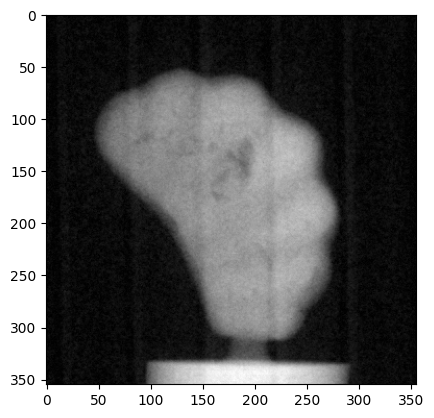

In [10]:
# Set boundaries for object, (atm>empiric)
plt.imshow(Z_corr[220:575,475:830,40], cmap="grey")

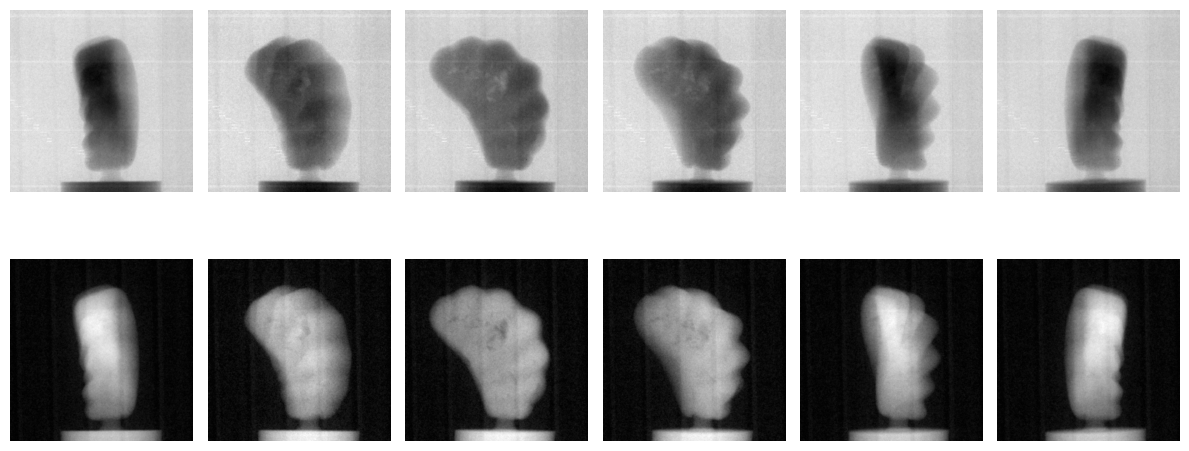

In [11]:
fig, axs = plt.subplots(2, 6, figsize=(12, 6))
axs[0,0].imshow(Z[220:575,475:830,0], cmap="grey")
axs[0,1].imshow(Z[220:575,475:830,20], cmap="grey")
axs[0,2].imshow(Z[220:575,475:830,40], cmap="grey")
axs[0,3].imshow(Z[220:575,475:830,60], cmap="grey")
axs[0,4].imshow(Z[220:575,475:830,80], cmap="grey")
axs[0,5].imshow(Z[220:575,475:830,99], cmap="grey")

axs[1,0].imshow(Z_corr[220:575,475:830,0], cmap="grey")
axs[1,1].imshow(Z_corr[220:575,475:830,20], cmap="grey")
axs[1,2].imshow(Z_corr[220:575,475:830,40], cmap="grey")
axs[1,3].imshow(Z_corr[220:575,475:830,60], cmap="grey")
axs[1,4].imshow(Z_corr[220:575,475:830,80], cmap="grey")
axs[1,5].imshow(Z_corr[220:575,475:830,99], cmap="grey")

for ax in axs.flat:
    ax.axis("off")

plt.subplots_adjust(hspace=0.000001, wspace=0.1)

plt.tight_layout()
plt.show()

In [12]:
# Create new arrays with cutout imgs
Z_prime = Z[220:575,475:830,:]
Z_corr_prime = Z_corr[220:575,475:830,:]

## (Img) Processing

### Correct Images with mask

In [13]:
# Apply all corrections and get Z_final

threshold_value = 0.1 * np.max(Z_corr_prime)

thresholded = np.where(Z_corr_prime > threshold_value, 1.0, 0.0)
thresholded_uint8 = (thresholded * 255).astype(np.uint8)

fullmask = np.zeros_like(Z_corr_prime, dtype=np.float32)
Z_final = np.zeros_like(Z_corr_prime)

# Get a binary 3d mask
for i in range(Z_corr_prime.shape[2]):
    contours, _ = cv2.findContours(thresholded_uint8[:,:,i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(Z_corr_prime[:,:,i], dtype=np.float32)
    cv2.drawContours(mask, contours, -1, (1.0), thickness=cv2.FILLED)
    fullmask[:,:,i] = mask
    # Z_final[:,:,i] = Z_corr_prime[:,:,i] * mask

Z_final = Z_corr_prime * fullmask
    


### Ignore: Img Data Analysis

(array([[182., 150.,  23., ...,   0.,   0.,   0.],
        [202., 137.,  16., ...,   0.,   0.,   0.],
        [214., 128.,  13., ...,   0.,   0.,   0.],
        ...,
        [310.,  45.,   0., ...,   0.,   0.,   0.],
        [291.,  62.,   2., ...,   0.,   0.,   0.],
        [275.,  72.,   8., ...,   0.,   0.,   0.]]),
 array([0.        , 0.00036488, 0.00072976, 0.00109464, 0.00145952,
        0.0018244 , 0.00218928, 0.00255417, 0.00291905, 0.00328393,
        0.00364881, 0.00401369, 0.00437857, 0.00474345, 0.00510833,
        0.00547321, 0.00583809, 0.00620297, 0.00656785, 0.00693273,
        0.00729761, 0.0076625 , 0.00802738, 0.00839226, 0.00875714,
        0.00912202, 0.0094869 , 0.00985178, 0.01021666, 0.01058154,
        0.01094642]),
 <a list of 355 BarContainer objects>)

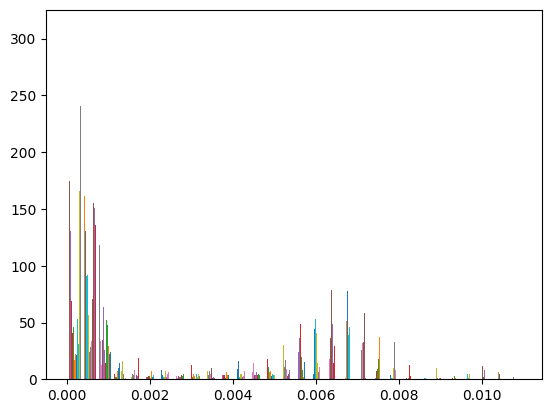

In [14]:
plt.hist(Z_corr_prime[:,:,40], density=False, bins=30)

(array([86431., 36096.,  3498.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 

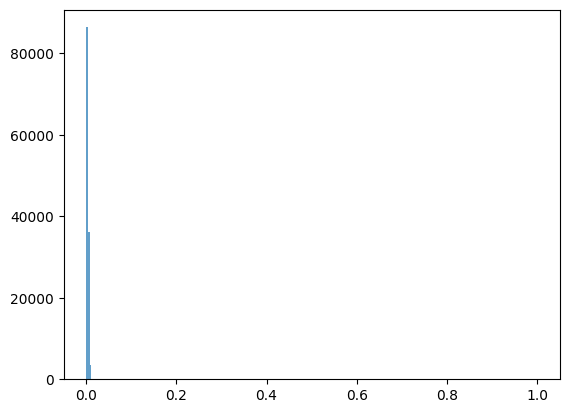

In [15]:
plt.hist(Z_corr_prime[:,:,40].ravel(), bins=256, range=(0.0, 1.0), alpha=0.7)

### Ignore: Median filter application

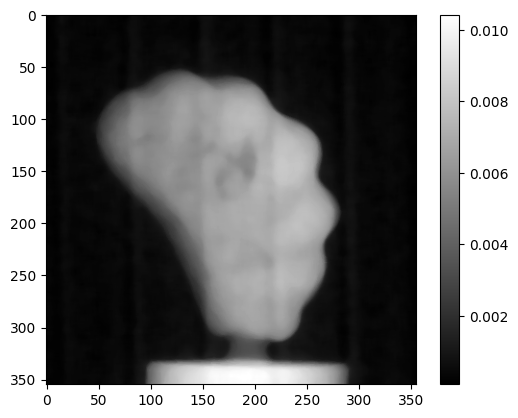

In [16]:
from scipy.ndimage import median_filter

# Apply median filter to the image
filtered_image = median_filter(Z_corr_prime[:,:,50], size=(10, 10))  # Adjust size as needed
plt.imshow(filtered_image, cmap='gray')
plt.colorbar()
plt.show()

## 3D Reconstruction

In [17]:
theta = np.linspace(0.,180.,Z.shape[2], endpoint=False)

In [18]:
theta = np.linspace(0.,180.,Z.shape[2], endpoint=False)

FB_final = np.zeros((Z_final.shape[1],Z_final.shape[1],Z_final.shape[0]))
for i in range(Z_final.shape[0]):
    S = np.squeeze(Z_final[i,:,:])
    FB_final[:,:,i] = iradon(S, theta=theta)

### Ignore: Some more analysis

In [19]:
# FB = np.zeros((Z_prime.shape[1],Z_prime.shape[1],Z_prime.shape[0]))
# for i in range(Z_prime.shape[0]):
#     S = np.squeeze(Z_prime[i,:,:])
#     FB[:,:,i] = iradon(S, theta=theta)

In [20]:
# FB_corr = np.zeros((Z_corr_prime.shape[1],Z_corr_prime.shape[1],Z_corr_prime.shape[0]))
# for i in range(Z_corr_prime.shape[0]):
#     S = np.squeeze(Z_corr_prime[i,:,:])
#     FB_corr[:,:,i] = iradon(S, theta=theta)

In [ ]:
# plt.imshow(np.squeeze(Z_corr_prime[150,:,:]))

In [ ]:
# Ma = np.max(FB[:])
# Mi = np.min(FB[:])

# plt.imshow(FB[:,:,150], vmax=Ma*0.1, vmin=0, cmap='grey')
# plt.colorbar()

### Napari

In [23]:
import napari
viewer = napari.Viewer()
viewer.dims.ndisplay = 3
viewer.add_image(FB_final)

<Image layer 'FB_final' at 0x215b4027980>

### Ignore: Area to be corrected

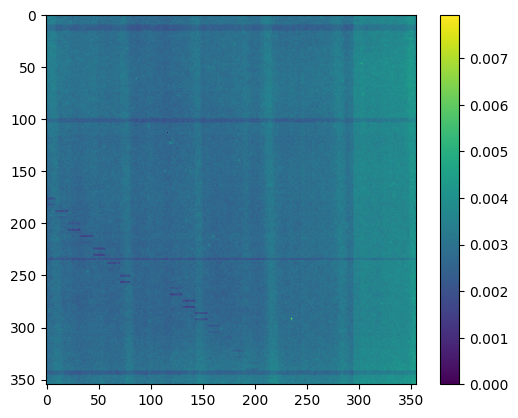

In [24]:
plt.imshow(1-(img_empty[220:575,475:830]/np.max(img_empty[220:575,475:830])))
plt.colorbar()

## Prepare cutout sim

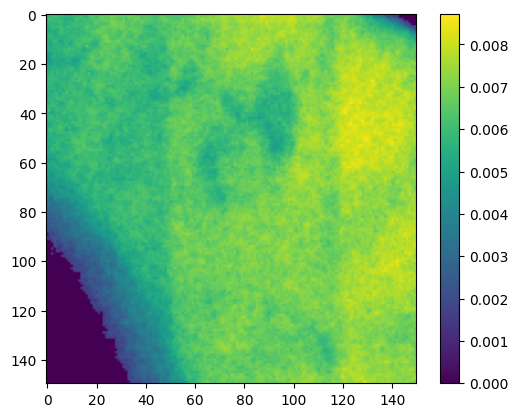

In [25]:
# Use arrays from above
plt.imshow(Z_final[100:250,100:250,50])
plt.colorbar()

In [26]:
Z_final_cutout = np.zeros_like(Z_final,dtype=np.float32)
Z_final_cutout[100:250,100:250,:] = Z_final[100:250,100:250,:]

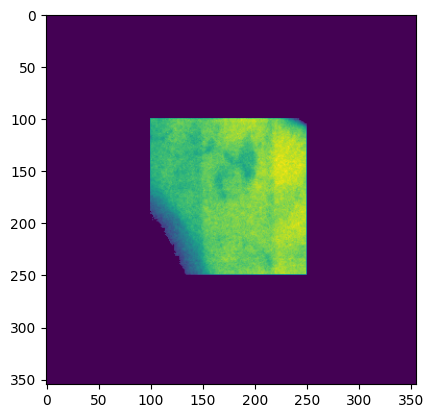

In [27]:
plt.imshow(Z_final_cutout[:,:,50])

In [28]:
theta = np.linspace(0.,180.,Z.shape[2], endpoint=False)

FB_final_cutout = np.zeros((Z_final_cutout.shape[1],Z_final_cutout.shape[1],Z_final_cutout.shape[0]))
for i in range(Z_final_cutout.shape[0]):
    S = np.squeeze(Z_final_cutout[i,:,:])
    FB_final_cutout[:,:,i] = iradon(S, theta=theta)

In [29]:
import napari
viewer = napari.Viewer()
viewer.dims.ndisplay = 3
viewer.add_image(FB_final_cutout)

<Image layer 'FB_final_cutout' at 0x215e2586720>

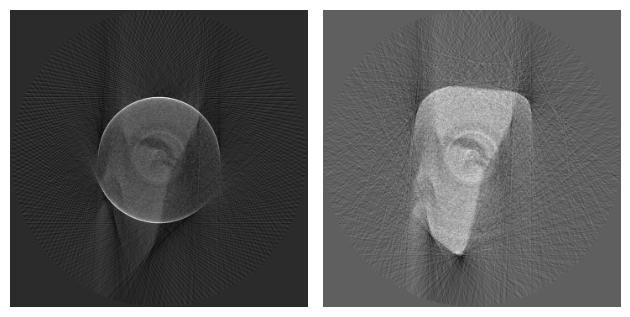

In [30]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(FB_final_cutout[:,:,150],cmap='grey')
axs[1].imshow(FB_final[:,:,150],cmap='grey')

for ax in axs.flat:
    ax.axis("off")

plt.subplots_adjust(hspace=0.000001, wspace=0.1)

plt.tight_layout()
plt.show()